This notebook presents the appplication of Bayesian Optimisation to the problem of optimally controlling the 
stretcher parameters of the L1 pump Laser.

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

# Setting
The goal of this project is to maximise second-harmonic efficiency. 

However, since this metric is also very much related to the shortest possible pulse shape, we developed a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which is, by default, the shortest one).

This process is very much intensive for what concerns the number of function evaluation we needed to use and, because of that, we resorted to use a custom-built fast-running forward model used to approximate/predict the temporal  profile of the pulse given a set of parameters. 

In particular, if one indicates with $\psi = \big( d_1, d_2, d_3 \big)$ the control configuration of the stretcher and with $E(\nu)$ the electric field in the frequency domain of the signal considered, then the fast running model we developed approximates $ \tilde{\tau}(\psi; E(\nu)) $, hopefully similar enough to the actual ${\tau}(\psi; E(\nu))$ that can be collected only through practical observation on the real hardware. 

If one has a target temporal profile $\tau^*$ of the pulse then it the problem can be framed as: 

$$\min_{\psi} L\big[ \tilde{\tau}(\psi; E(\nu)), \tau^*\big]$$

With $L$ being some sort of loss function. 

The solution of this problem can be obtained, in principle, using Bayesian Optimisation. In this notebook, this is the approach that is tried out. 

In [1]:
# these imports are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("..")

from algorithms.L1_BayesianOptimisation import *
from utils import physics

In [2]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))
# pre-processed version of frequency and intensity
frequency_clean, intensity_clean = l1_pump.spit_center()

# target temporal profile shape
_, target_profile = physics.temporal_profile(frequency_clean, np.sqrt(intensity_clean),
                                             phase = np.zeros_like(frequency_clean),
                                             npoints_pad = l1_pump.pad_points)

temporal_profile = lambda d2, d3, d4: l1_pump.forward_pass(np.array((d2, d3, d4)))[1]
objective_function = lambda d2, d3, d4: -1 * physics.mse(temporal_profile(d2, d3, d4), target_profile)

The bounds of the optimisation process are defined considering that: 

1. The value of GDD is tunable only in a region which is a little bit more than $\pm$ 10% of its nominal value.

2. TOD is tunable practically without limits in the case in which the bounds are defined using percentages of the nominal values. 

3. FOD is tunable practically without limits in the case in which the bounds are defined using percentages of the nomnal values. 

In [3]:
GDDperc, TODperc, FODperc = 0.05, 0.2, 0.3
# stretcher control bounds are centered in the compressor bounds and have a width related to a given percentage
# (which can be though of as an hyperparameter as long as it is in the tunable interval)

low_stretcher, high_stretcher = (-1 * COMPRESSOR * np.array((1 - GDDperc, 1 - TODperc, 1 - FODperc)), 
                                 -1 * COMPRESSOR * np.array((1 + GDDperc, 1 + TODperc, 1 + FODperc))
                                )

# stretcher control must be given in terms of dispersion coefficients so they must be translated into d2, d3 and d4. 
low_stretcher, high_stretcher = (l1_pump.translate_control(low_stretcher, verse = "to_disp"),
                                 l1_pump.translate_control(high_stretcher, verse = "to_disp")
                                )

# these are the bounds for the parameter currently optimized - sign can change so sorting is used
pbounds = {
    "d2": np.sort((low_stretcher[0], high_stretcher[0])), 
    "d3": np.sort((low_stretcher[1], high_stretcher[1])), 
    "d4": np.sort((low_stretcher[2], high_stretcher[2]))
}

In [4]:
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=10, # for reproducibility
)

# these are the actual hyperparameters of the optimization process
n_init, n_iter = 150, 200

optimizer.maximize(
    init_points=n_init,
    n_iter=n_iter,
)

|   iter    |  target   |    d2     |    d3     |    d4     |
-------------------------------------------------------------
|  2        | -0.004684 | -0.4623   | -6.578e+0 | -5.743e+1 |
|  3        | -0.001892 | -0.4884   | -5.817e+0 | -5.912e+1 |
|  9        | -0.000330 | -0.4769   | -6.765e+0 | -4.556e+1 |
|  20       | -0.000273 | -0.4762   | -5.626e+0 | -5.663e+1 |
|  31       | -0.000226 | -0.4753   | -7.176e+0 | -6.228e+1 |
|  125      | -0.000221 | -0.4752   | -6.409e+0 | -5.091e+1 |
|  189      | -0.000206 | -0.4748   | -6.879e+0 | -5.221e+1 |


In [5]:
# plotting the result obtained with Bayesian Optimization
optimald2, optimald3, optimald4 = optimizer.max["params"]["d2"], optimizer.max["params"]["d3"], optimizer.max["params"]["d4"]

optimal_control = (optimald2, optimald3, optimald4)
# applying optimal control found
time_BO, profile_BO = l1_pump.forward_pass(optimal_control)

print("Final MSE between Control and Target: {:.4e}".format(-1*objective_function(optimald2, optimald3, optimald4)))

Final MSE between Control and Target: 2.0639e-04


Typically Bayesian Optimisation is really sample-efficient for what concerns the number of function evaluations so 350 iterations should really be enough. 

The result of such iterations are presented in the the following Figure. 

In [6]:
# output if non-linearity was absent from the system 
linear_opt_time, linear_opt_profile = l1_pump.forward_pass(
    control = l1_pump.translate_control(
        -1*COMPRESSOR, verse = "to_disp"
    )
)

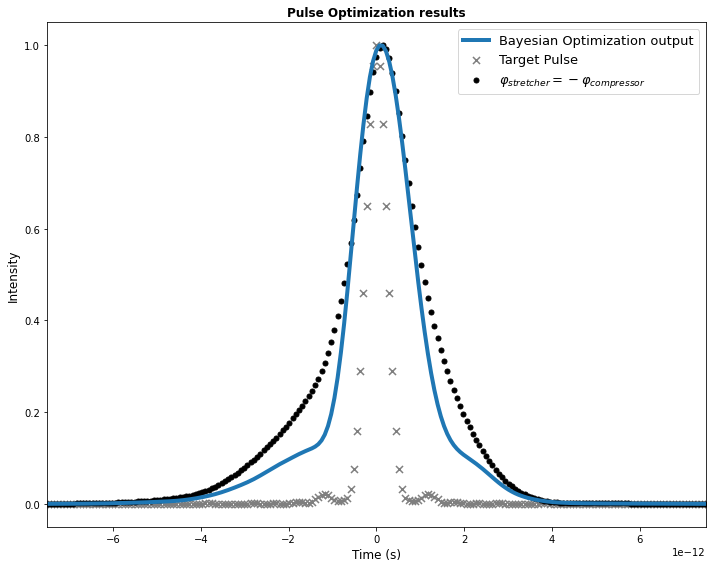

In [7]:
control = np.array((optimizer.max["params"]["d2"], optimizer.max["params"]["d3"], optimizer.max["params"]["d4"]))
time_BO, profile_BO = l1_pump.forward_pass(control)
#profile_BO = np.roll(profile_BO, np.argmax(target_profile) - np.argmax(profile_BO))

fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title("Pulse Optimization results", fontsize = 12, fontweight = "bold")
ax.plot(time_BO, profile_BO, label = "Bayesian Optimization output", lw = 4)
ax.scatter(time_BO, target_profile, label = "Target Pulse", c = "tab:grey", marker = "x", s = 50)
ax.scatter(linear_opt_time, linear_opt_profile, label = r"$\varphi_{stretcher} = - \varphi_{compressor}$", marker = "o", s = 25, c = "k")

ax.set_xlabel(r"Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)

ax.legend(fontsize = 13)
ax.set_xlim(left = -0.75e-11, right = +0.75e-11)
fig.tight_layout()
plt.show()

The above Figure shows: 
1. Target Pulse: defined as the Transform Limited pulse (the one having $\varphi = 0$) of the given spectrum. 

2. The temporal profile of the controlled pulse when the phase of the stretcher is equal and opposite to the one of the compressor (this would be the transform limited pulse if no non-linear effect were present in the system)

3. The Bayesian Optimisation output, which is as it is possible to see not converging to the desired shape even if it certainly does approach a shape way more quasi-Gaussian than the ideal linear control. 

Considering these results, we decided to: 

1. Investigate more hyper-parameters, such as the exploration-exploitation parameter to name one, and see how performance might change. 

2. Investigate other algorithms to carry out the task. 